# Natural Stories Corpus: Word Processing Analysis

**Date:** February 17, 2026

Analysis of relationships between word properties (length, frequency, GPT-3 probabilities) and reading times.

**Data Sources:**
- Reading Times: `processed_RTs.tsv`
- Frequencies: `freq/freqs-*.tsv` (Google Books)
- GPT-3 Probabilities: `all_stories_gpt3.csv`

In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data if needed
try:
    stopwords.words('english')
except:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## Data Loading

In [11]:
# Load all data files
rt_data = pd.read_csv('processed_RTs.tsv', sep='\t')
gpt3_data = pd.read_csv('all_stories_gpt3.csv')
freqs_1 = pd.read_csv('freq/freqs-1.tsv', sep='\t', header=None, 
                      names=['token_id', 'ngram_order', 'word', 'freq', 'context_freq'])
words_data = pd.read_csv('naturalstories-master/words.tsv', sep='\t', header=None,
                         names=['token_id', 'word'])

# Filter for more token types to get better coverage
# Use .word, .whole, and numbered sub-tokens
freqs_word = freqs_1[freqs_1['token_id'].str.contains(r'\.(word|whole|\d+)$', regex=True)].copy()

print(f"Data loaded: {len(rt_data)} RT observations, {len(freqs_word)} frequency entries, {len(gpt3_data)} GPT-3 tokens")

Data loaded: 848875 RT observations, 32342 frequency entries, 12373 GPT-3 tokens


# Part I: Preliminary Analysis

## 1. Compute Mean RT per Word

In [12]:
# Per a.md: "For each word in the RT file, compute average RT across all subjects"
# This means: one mean RT per word TOKEN (word at specific zone), averaged across subjects
mean_rt_per_word = rt_data.groupby(['item', 'zone', 'word'])['RT'].agg(['mean', 'std', 'count']).reset_index()
mean_rt_per_word.columns = ['item', 'zone', 'word', 'mean_RT', 'std_RT', 'n_observations']
mean_rt_per_word['word_length'] = mean_rt_per_word['word'].str.len()
mean_rt_per_word['word_lower'] = mean_rt_per_word['word'].str.lower().str.strip()

print(f"Word tokens: {len(mean_rt_per_word)} | Mean RT: {mean_rt_per_word['mean_RT'].mean():.2f} ms")
mean_rt_per_word.head(10)

Word tokens: 10256 | Mean RT: 338.17 ms


,item,zone,word,mean_RT,std_RT,n_observations,word_length,word_lower
0,1,1,If,578.964286,276.061345,84,2,if
1,1,2,you,369.011905,160.579935,84,3,you
2,1,3,were,368.183908,168.027166,87,4,were
3,1,4,to,344.318182,224.916666,88,2,to
4,1,5,journey,354.639535,310.065644,86,7,journey
5,1,6,to,349.674157,198.212855,89,2,to
6,1,7,the,376.370787,334.078937,89,3,the
7,1,8,North,327.310345,181.580869,87,5,north
8,1,9,of,365.494382,336.905271,89,2,of
9,1,10,"England,",344.931034,207.073001,87,8,"england,"


## 2. Merge with Frequencies and GPT-3

In [13]:
# Aggregate frequencies by word (sum across sub-tokens for each word)
freqs_word['word_lower'] = freqs_word['word'].str.lower().str.strip()
freqs_aggregated = freqs_word.groupby('word_lower')['freq'].sum().reset_index()
freqs_aggregated.columns = ['word_lower', 'word_freq']

# Merge with mean RT data
data_merged = mean_rt_per_word.merge(freqs_aggregated, on='word_lower', how='left')
data_clean = data_merged[data_merged['word_freq'].notna()].copy()

print(f"After frequency merge: {len(data_clean)} observations")

# Prepare and merge GPT-3 data (average across positions for each word type)
gpt3_data['token_clean'] = gpt3_data['token'].str.strip().str.lower()
gpt3_data['neg_logprob'] = -gpt3_data['logprob']
gpt3_summary = gpt3_data.groupby('token_clean')['neg_logprob'].mean().reset_index()
gpt3_summary.columns = ['word_lower', 'gpt3_surprisal']

data_full = data_clean.merge(gpt3_summary, on='word_lower', how='left')
data_complete = data_full[data_full['gpt3_surprisal'].notna()].copy()
data_complete['log_freq'] = np.log10(data_complete['word_freq'] + 1)

print(f"Complete dataset: {len(data_complete)} word tokens with all features")
print(f"Mean RT: {data_complete['mean_RT'].mean():.2f} ms")
print(f"Unique word types: {data_complete['word_lower'].nunique()}")
data_complete[['item', 'zone', 'word', 'mean_RT', 'word_length', 'log_freq', 'gpt3_surprisal']].head(10)

After frequency merge: 8870 observations
Complete dataset: 8525 word tokens with all features
Mean RT: 334.73 ms
Unique word types: 1757


,item,zone,word,mean_RT,word_length,log_freq,gpt3_surprisal
0,1,1,If,578.964286,2,9.824737,3.474218
1,1,2,you,369.011905,3,10.695291,1.347071
2,1,3,were,368.183908,4,10.929908,1.546318
3,1,4,to,344.318182,2,12.494993,1.062278
4,1,5,journey,354.639535,7,7.788457,4.492284
5,1,6,to,349.674157,2,12.494993,1.062278
6,1,7,the,376.370787,3,13.328869,1.226596
7,1,8,North,327.310345,5,7.859876,4.631145
8,1,9,of,365.494382,2,12.626719,0.544737
9,1,11,you,400.269663,3,10.695291,1.347071


## 3. Plot Word Length vs Mean RT

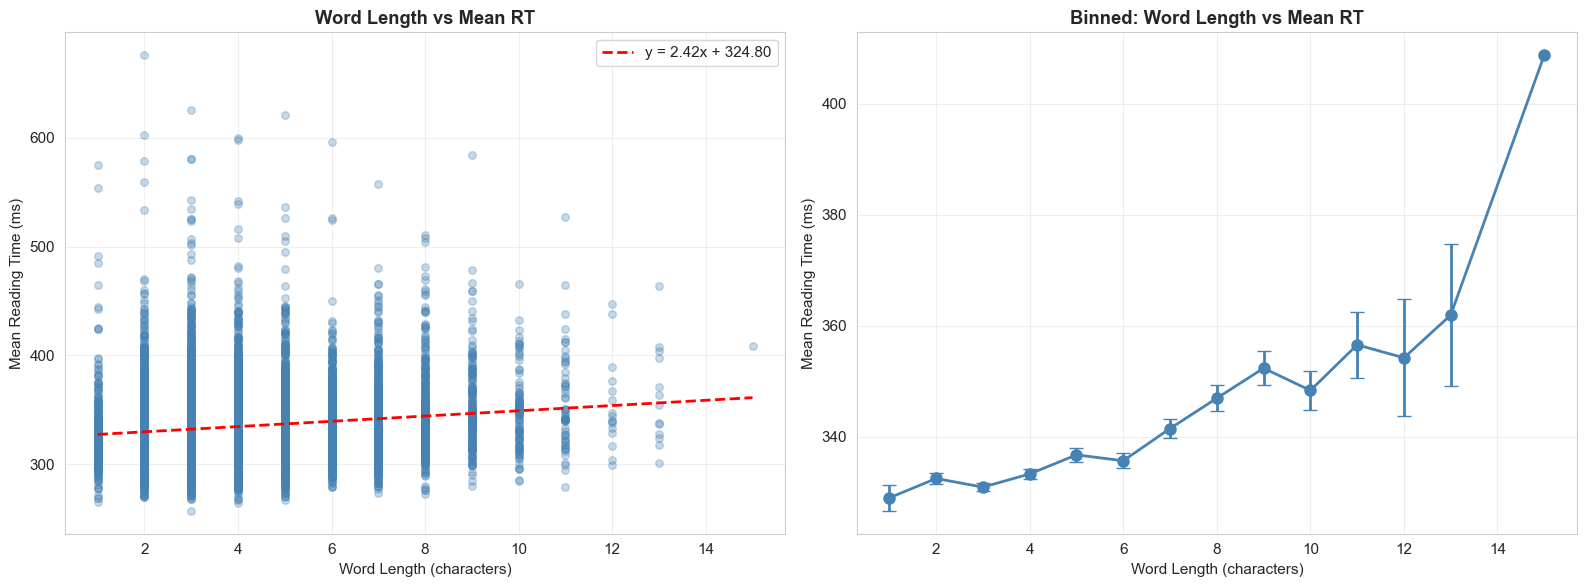

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1.scatter(data_complete['word_length'], data_complete['mean_RT'], alpha=0.3, s=30, color='steelblue')
z = np.polyfit(data_complete['word_length'], data_complete['mean_RT'], 1)
p = np.poly1d(z)
ax1.plot(data_complete['word_length'].sort_values(), p(data_complete['word_length'].sort_values()), 
        "r--", linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
ax1.set_xlabel('Word Length (characters)')
ax1.set_ylabel('Mean Reading Time (ms)')
ax1.set_title('Word Length vs Mean RT', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Binned plot
length_bins = data_complete.groupby('word_length')['mean_RT'].agg(['mean', 'std', 'count'])
ax2.errorbar(length_bins.index, length_bins['mean'], 
            yerr=length_bins['std']/np.sqrt(length_bins['count']),
            fmt='o-', color='steelblue', capsize=5, markersize=8, linewidth=2)
ax2.set_xlabel('Word Length (characters)')
ax2.set_ylabel('Mean Reading Time (ms)')
ax2.set_title('Binned: Word Length vs Mean RT', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plot_length_vs_rt.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Plot Word Frequency vs Mean RT

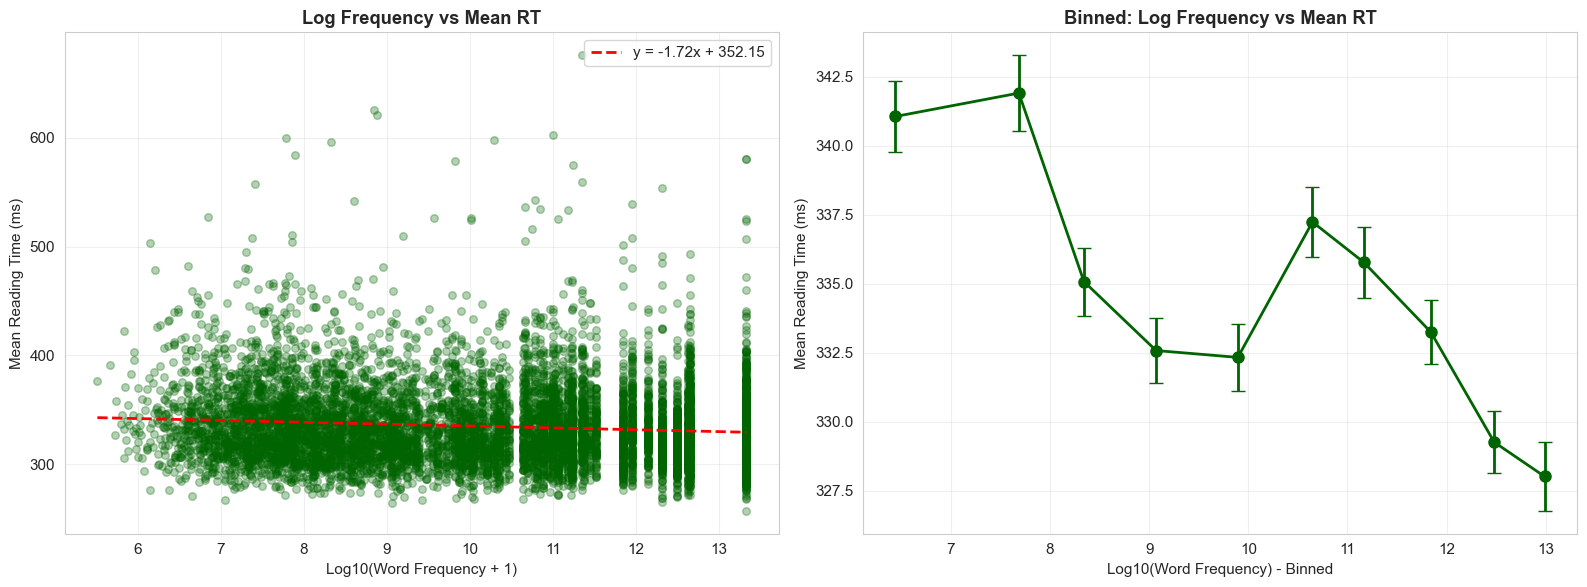

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Log frequency scatter
ax1.scatter(data_complete['log_freq'], data_complete['mean_RT'], alpha=0.3, s=30, color='darkgreen')
z = np.polyfit(data_complete['log_freq'], data_complete['mean_RT'], 1)
p = np.poly1d(z)
ax1.plot(data_complete['log_freq'].sort_values(), p(data_complete['log_freq'].sort_values()), 
        "r--", linewidth=2, label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
ax1.set_xlabel('Log10(Word Frequency + 1)')
ax1.set_ylabel('Mean Reading Time (ms)')
ax1.set_title('Log Frequency vs Mean RT', fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Binned plot
data_complete['freq_bin'] = pd.qcut(data_complete['log_freq'], q=10, duplicates='drop')
freq_bins = data_complete.groupby('freq_bin')['mean_RT'].agg(['mean', 'std', 'count'])
freq_bins['midpoint'] = [interval.mid for interval in freq_bins.index]
ax2.errorbar(freq_bins['midpoint'], freq_bins['mean'], 
            yerr=freq_bins['std']/np.sqrt(freq_bins['count']),
            fmt='o-', color='darkgreen', capsize=5, markersize=8, linewidth=2)
ax2.set_xlabel('Log10(Word Frequency) - Binned')
ax2.set_ylabel('Mean Reading Time (ms)')
ax2.set_title('Binned: Log Frequency vs Mean RT', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plot_frequency_vs_rt.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Correlation Analysis


Correlation Results:
Length × Frequency:  r = -0.7180, p = 0.0000e+00
Length × RT:         r = 0.1371, p = 4.8214e-37
Frequency × RT:      r = -0.0956, p = 8.7802e-19
GPT-3 Surprisal × RT: r = 0.0768, p = 1.2159e-12


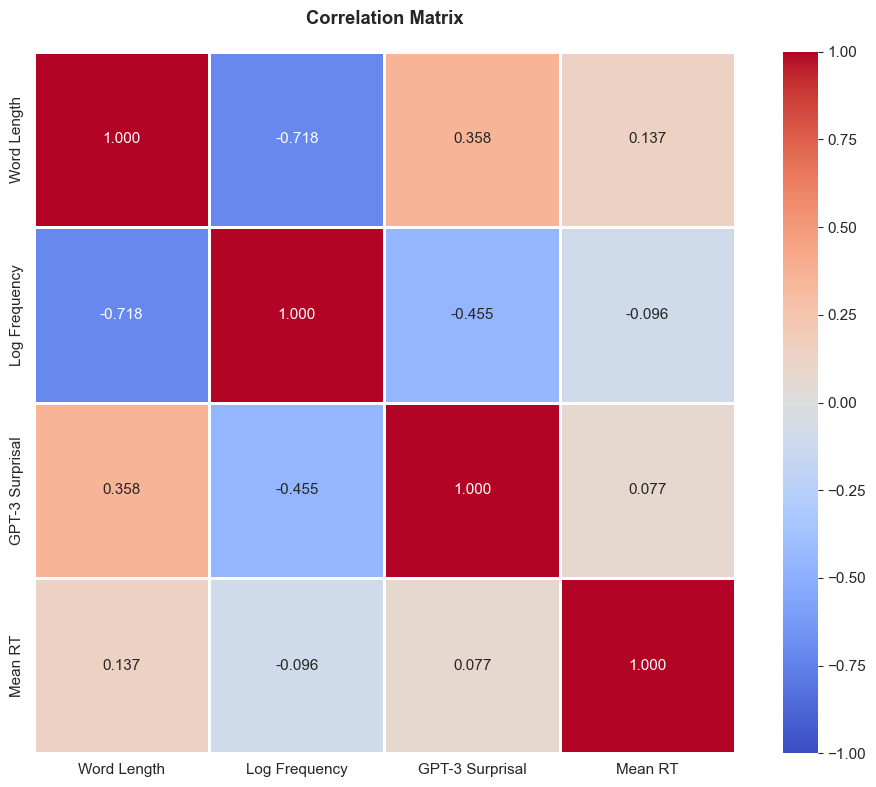

In [16]:
# Compute all correlations
corr_len_freq, p_len_freq = pearsonr(data_complete['word_length'], data_complete['log_freq'])
corr_len_rt, p_len_rt = pearsonr(data_complete['word_length'], data_complete['mean_RT'])
corr_freq_rt, p_freq_rt = pearsonr(data_complete['log_freq'], data_complete['mean_RT'])
corr_gpt_rt, p_gpt_rt = pearsonr(data_complete['gpt3_surprisal'], data_complete['mean_RT'])

print("\nCorrelation Results:")
print(f"Length × Frequency:  r = {corr_len_freq:.4f}, p = {p_len_freq:.4e}")
print(f"Length × RT:         r = {corr_len_rt:.4f}, p = {p_len_rt:.4e}")
print(f"Frequency × RT:      r = {corr_freq_rt:.4f}, p = {p_freq_rt:.4e}")
print(f"GPT-3 Surprisal × RT: r = {corr_gpt_rt:.4f}, p = {p_gpt_rt:.4e}")

# Correlation matrix
corr_vars = data_complete[['word_length', 'log_freq', 'gpt3_surprisal', 'mean_RT']].copy()
corr_vars.columns = ['Word Length', 'Log Frequency', 'GPT-3 Surprisal', 'Mean RT']
corr_matrix = corr_vars.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, 
            linewidths=1, fmt='.3f', vmin=-1, vmax=1)
plt.title('Correlation Matrix', fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Part II: Hypothesis Testing

## Hypothesis 1: GPT-3 vs Frequency as Predictor

In [17]:
# Prepare regression data
regression_data = data_complete[['mean_RT', 'word_length', 'log_freq', 'gpt3_surprisal']].dropna()
X_freq = regression_data[['log_freq', 'word_length']].values
X_gpt = regression_data[['gpt3_surprisal', 'word_length']].values
y = regression_data['mean_RT'].values

# Model 1: Frequency + Length
model1 = LinearRegression().fit(X_freq, y)
y_pred1 = model1.predict(X_freq)
r2_1 = r2_score(y, y_pred1)
rmse_1 = np.sqrt(mean_squared_error(y, y_pred1))
mae_1 = mean_absolute_error(y, y_pred1)

# Calculate AIC and BIC
n = len(y)
k1 = 3  # 2 predictors + intercept
rss1 = np.sum((y - y_pred1)**2)
aic_1 = n * np.log(rss1/n) + 2*k1
bic_1 = n * np.log(rss1/n) + k1*np.log(n)

# Model 2: GPT-3 + Length
model2 = LinearRegression().fit(X_gpt, y)
y_pred2 = model2.predict(X_gpt)
r2_2 = r2_score(y, y_pred2)
rmse_2 = np.sqrt(mean_squared_error(y, y_pred2))
mae_2 = mean_absolute_error(y, y_pred2)

# Calculate AIC and BIC
k2 = 3
rss2 = np.sum((y - y_pred2)**2)
aic_2 = n * np.log(rss2/n) + 2*k2
bic_2 = n * np.log(rss2/n) + k2*np.log(n)

print(f"\nModel 1 (Frequency): R² = {r2_1:.4f}, RMSE = {rmse_1:.2f} ms, MAE = {mae_1:.2f} ms")
print(f"                     AIC = {aic_1:.2f}, BIC = {bic_1:.2f}")
print(f"\nModel 2 (GPT-3):     R² = {r2_2:.4f}, RMSE = {rmse_2:.2f} ms, MAE = {mae_2:.2f} ms")
print(f"                     AIC = {aic_2:.2f}, BIC = {bic_2:.2f}")
print(f"\nBetter Model: {'GPT-3' if r2_2 > r2_1 else 'Frequency'} (ΔR² = {abs(r2_2-r2_1):.4f})")


Model 1 (Frequency): R² = 0.0188, RMSE = 36.21 ms, MAE = 26.61 ms
                     AIC = 61203.61, BIC = 61224.76

Model 2 (GPT-3):     R² = 0.0197, RMSE = 36.19 ms, MAE = 26.59 ms
                     AIC = 61196.10, BIC = 61217.25

Better Model: GPT-3 (ΔR² = 0.0009)


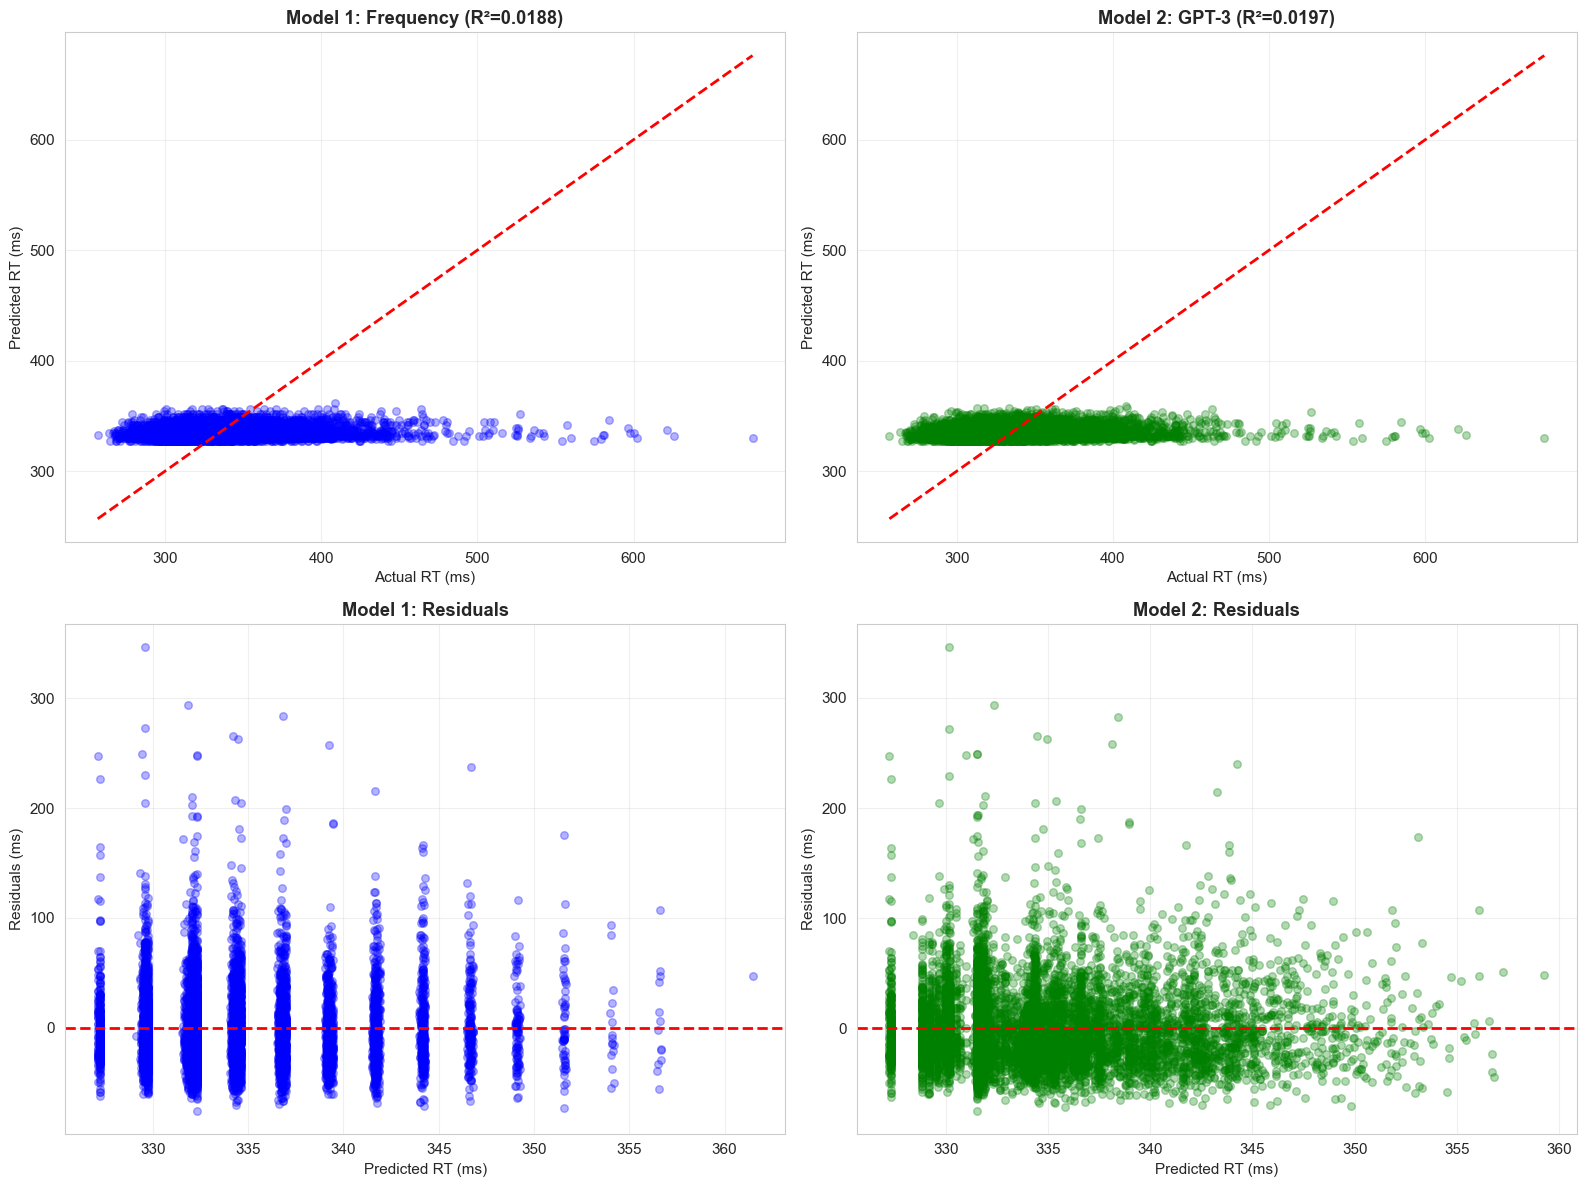

In [18]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Model 1 predictions
axes[0, 0].scatter(y, y_pred1, alpha=0.3, s=30, color='blue')
axes[0, 0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual RT (ms)')
axes[0, 0].set_ylabel('Predicted RT (ms)')
axes[0, 0].set_title(f'Model 1: Frequency (R²={r2_1:.4f})', fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Model 2 predictions
axes[0, 1].scatter(y, y_pred2, alpha=0.3, s=30, color='green')
axes[0, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual RT (ms)')
axes[0, 1].set_ylabel('Predicted RT (ms)')
axes[0, 1].set_title(f'Model 2: GPT-3 (R²={r2_2:.4f})', fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Residuals
axes[1, 0].scatter(y_pred1, y - y_pred1, alpha=0.3, s=30, color='blue')
axes[1, 0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Predicted RT (ms)')
axes[1, 0].set_ylabel('Residuals (ms)')
axes[1, 0].set_title('Model 1: Residuals', fontweight='bold')
axes[1, 0].grid(alpha=0.3)

axes[1, 1].scatter(y_pred2, y - y_pred2, alpha=0.3, s=30, color='green')
axes[1, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1, 1].set_xlabel('Predicted RT (ms)')
axes[1, 1].set_ylabel('Residuals (ms)')
axes[1, 1].set_title('Model 2: Residuals', fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hypothesis1_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Hypothesis 2: Content vs Function Words

In [19]:
# Use NLTK stopwords for function word classification (matches 1a.md)
function_words = set(stopwords.words('english'))

# Classify unique words only (much faster)
unique_words = data_complete.loc[regression_data.index, 'word'].unique()
word_type_map = {}

for word in unique_words:
    word_lower = word.lower()
    if word_lower in function_words:
        word_type_map[word] = 'function'
    else:
        word_type_map[word] = 'content'

# Map to dataframe
regression_data['word_type'] = regression_data.index.map(
    lambda idx: word_type_map[data_complete.loc[idx, 'word']]
)

content_data = regression_data[regression_data['word_type'] == 'content'].copy()
function_data = regression_data[regression_data['word_type'] == 'function'].copy()

print(f"\nContent words: {len(content_data)} | Function words: {len(function_data)}")
print(f"Content mean RT: {content_data['mean_RT'].mean():.2f} ms")
print(f"Function mean RT: {function_data['mean_RT'].mean():.2f} ms")

t_stat, p_val = ttest_ind(content_data['mean_RT'], function_data['mean_RT'])
print(f"T-test: t={t_stat:.4f}, p={p_val:.4e}")


Content words: 3683 | Function words: 4842
Content mean RT: 337.20 ms
Function mean RT: 332.86 ms
T-test: t=5.4374, p=5.5563e-08


In [20]:
# Content word models
X_c1 = content_data[['log_freq', 'word_length']].values
X_c2 = content_data[['gpt3_surprisal', 'word_length']].values
y_c = content_data['mean_RT'].values

model_c1 = LinearRegression().fit(X_c1, y_c)
model_c2 = LinearRegression().fit(X_c2, y_c)
r2_c1 = r2_score(y_c, model_c1.predict(X_c1))
r2_c2 = r2_score(y_c, model_c2.predict(X_c2))

# Function word models
X_f1 = function_data[['log_freq', 'word_length']].values
X_f2 = function_data[['gpt3_surprisal', 'word_length']].values
y_f = function_data['mean_RT'].values

model_f1 = LinearRegression().fit(X_f1, y_f)
model_f2 = LinearRegression().fit(X_f2, y_f)
r2_f1 = r2_score(y_f, model_f1.predict(X_f1))
r2_f2 = r2_score(y_f, model_f2.predict(X_f2))

print(f"\nContent: Freq R²={r2_c1:.4f} | GPT-3 R²={r2_c2:.4f}")
print(f"Function: Freq R²={r2_f1:.4f} | GPT-3 R²={r2_f2:.4f}")


Content: Freq R²=0.0340 | GPT-3 R²=0.0334
Function: Freq R²=0.0077 | GPT-3 R²=0.0147


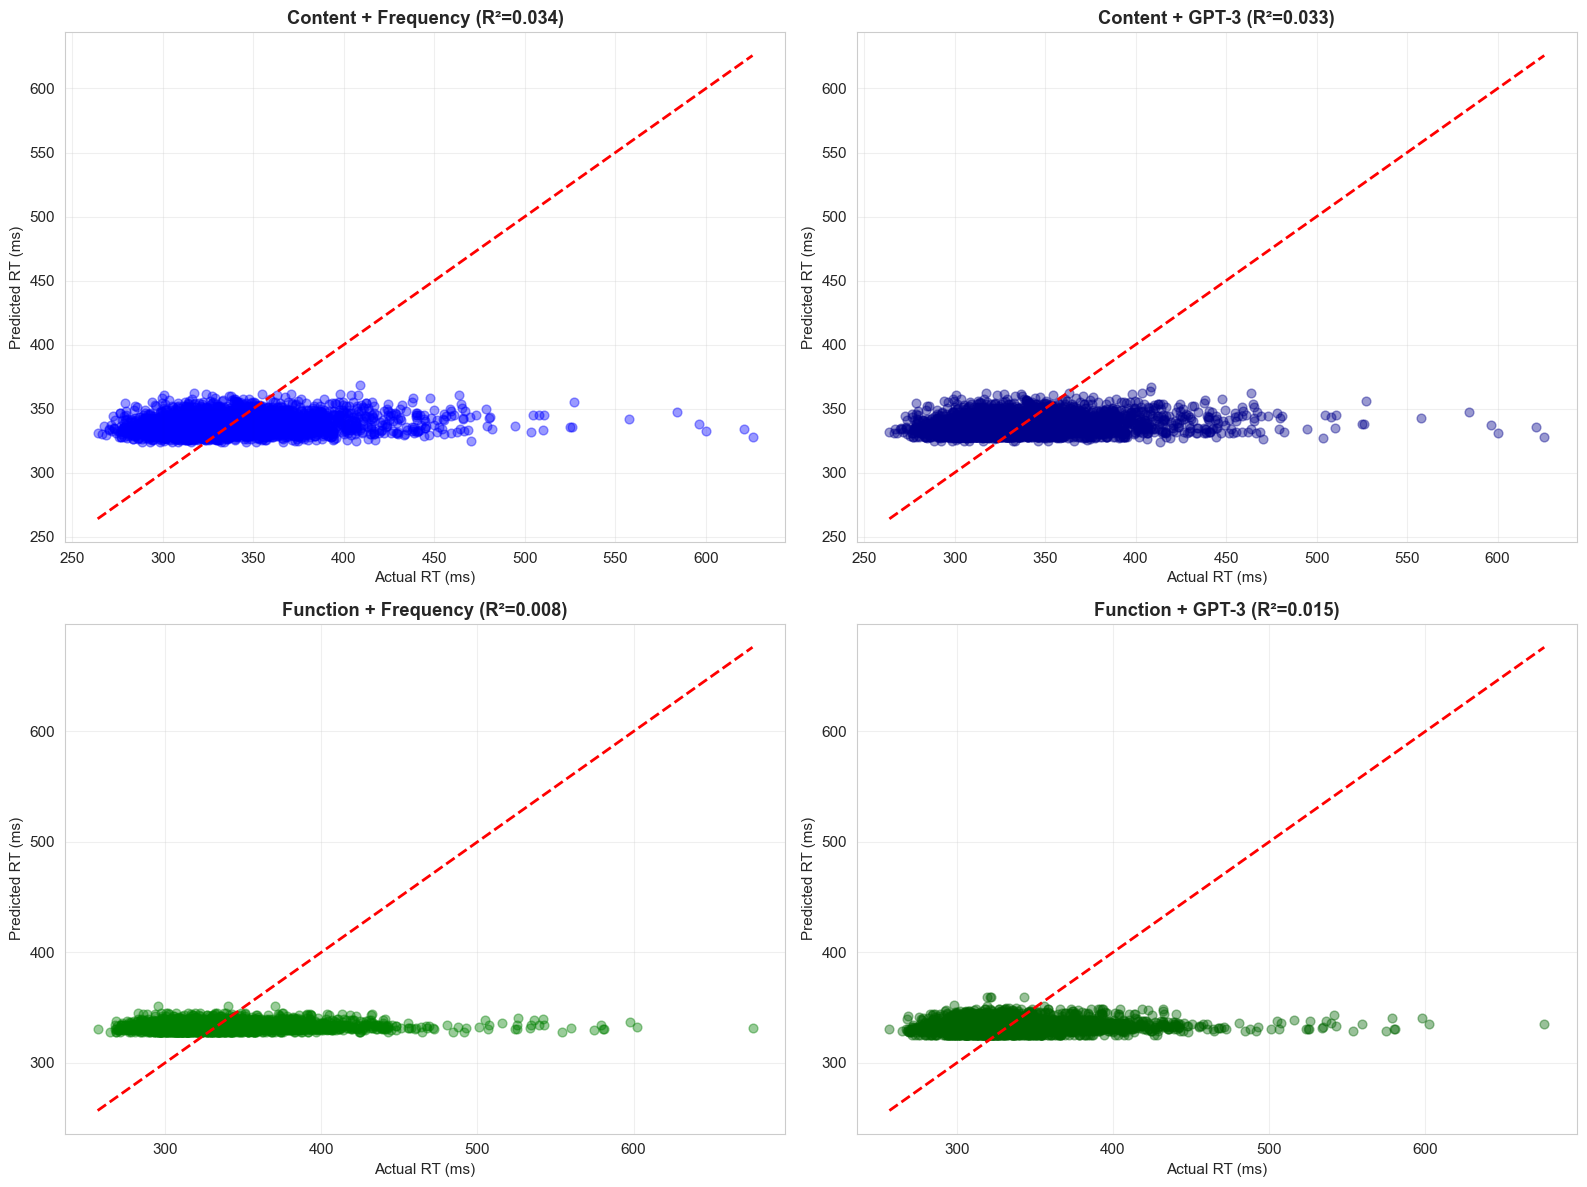

In [27]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

y_pred_c1 = model_c1.predict(X_c1)
y_pred_c2 = model_c2.predict(X_c2)
y_pred_f1 = model_f1.predict(X_f1)
y_pred_f2 = model_f2.predict(X_f2)

axes[0, 0].scatter(y_c, y_pred_c1, alpha=0.4, s=40, color='blue')
axes[0, 0].plot([y_c.min(), y_c.max()], [y_c.min(), y_c.max()], 'r--', lw=2)
axes[0, 0].set_title(f'Content + Frequency (R²={r2_c1:.3f})', fontweight='bold')
axes[0, 0].set_xlabel('Actual RT (ms)')
axes[0, 0].set_ylabel('Predicted RT (ms)')

axes[0, 1].scatter(y_c, y_pred_c2, alpha=0.4, s=40, color='darkblue')
axes[0, 1].plot([y_c.min(), y_c.max()], [y_c.min(), y_c.max()], 'r--', lw=2)
axes[0, 1].set_title(f'Content + GPT-3 (R²={r2_c2:.3f})', fontweight='bold')
axes[0, 1].set_xlabel('Actual RT (ms)')
axes[0, 1].set_ylabel('Predicted RT (ms)')

axes[1, 0].scatter(y_f, y_pred_f1, alpha=0.4, s=40, color='green')
axes[1, 0].plot([y_f.min(), y_f.max()], [y_f.min(), y_f.max()], 'r--', lw=2)
axes[1, 0].set_title(f'Function + Frequency (R²={r2_f1:.3f})', fontweight='bold')
axes[1, 0].set_xlabel('Actual RT (ms)')
axes[1, 0].set_ylabel('Predicted RT (ms)')

axes[1, 1].scatter(y_f, y_pred_f2, alpha=0.4, s=40, color='darkgreen')
axes[1, 1].plot([y_f.min(), y_f.max()], [y_f.min(), y_f.max()], 'r--', lw=2)
axes[1, 1].set_title(f'Function + GPT-3 (R²={r2_f2:.3f})', fontweight='bold')
axes[1, 1].set_xlabel('Actual RT (ms)')
axes[1, 1].set_ylabel('Predicted RT (ms)')

for ax in axes.flat:
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('hypothesis2_content_vs_function.png', dpi=300, bbox_inches='tight')
plt.show()

---
# Part III: FOBS Model

## Lemmatization and Root Frequency

In [21]:
# Lemmatize using spaCy - optimize by processing only unique words
unique_words = data_complete['word'].unique()
print(f"Lemmatizing {len(unique_words):,} unique words...")

word_to_lemma = {}
for word in unique_words:
    try:
        doc = nlp(word.lower())
        word_to_lemma[word] = doc[0].lemma_ if len(doc) > 0 else word.lower()
    except:
        word_to_lemma[word] = word.lower()

data_complete['lemma'] = data_complete['word'].map(word_to_lemma)
data_complete['lemma_length'] = data_complete['lemma'].str.len()

# Calculate lemma frequencies (sum across surface forms) - use groupby for efficiency
lemma_freq_df = data_complete.groupby('lemma')['word_freq'].sum().reset_index()
lemma_freq_dict = dict(zip(lemma_freq_df['lemma'], lemma_freq_df['word_freq']))

data_complete['lemma_freq'] = data_complete['lemma'].map(lemma_freq_dict)
data_complete['log_lemma_freq'] = np.log10(data_complete['lemma_freq'] + 1)

print(f"Unique lemmas: {len(lemma_freq_dict)}")
print("\nTop 10 lemmas by frequency:")
for lemma, freq in sorted(lemma_freq_dict.items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {lemma}: {freq:,}")

Lemmatizing 1,857 unique words...
Unique lemmas: 1432

Top 10 lemmas by frequency:
  the: 1.684597047093492e+16
  and: 1,332,351,077,473,058.0
  of: 977,981,711,710,311.0
  to: 778,380,410,725,365.0
  a: 457,551,894,621,474.0
  in: 212,923,485,905,734.0
  be: 163,261,069,828,920.0
  that: 152,585,519,859,779.0
  as: 34,051,580,940,012.0
  it: 22,949,044,810,494.0


## Hypothesis 1: Root vs Surface Frequency

In [22]:
# Prepare data
part3_data = data_complete[['mean_RT', 'word_length', 'log_freq', 
                            'lemma_length', 'log_lemma_freq']].dropna()

# Model 1: Surface frequency
X_p3_1 = part3_data[['log_freq', 'word_length']].values
y_p3 = part3_data['mean_RT'].values
model_p3_1 = LinearRegression().fit(X_p3_1, y_p3)
r2_p3_1 = r2_score(y_p3, model_p3_1.predict(X_p3_1))

# Model 2: Lemma frequency
X_p3_2 = part3_data[['log_lemma_freq', 'lemma_length']].values
model_p3_2 = LinearRegression().fit(X_p3_2, y_p3)
r2_p3_2 = r2_score(y_p3, model_p3_2.predict(X_p3_2))

print(f"\nSurface Frequency: R² = {r2_p3_1:.4f}")
print(f"Lemma Frequency:   R² = {r2_p3_2:.4f}")
print(f"\nBetter predictor: {'Lemma' if r2_p3_2 > r2_p3_1 else 'Surface'} (ΔR² = {abs(r2_p3_2-r2_p3_1):.4f})")


Surface Frequency: R² = 0.0188
Lemma Frequency:   R² = 0.0192

Better predictor: Lemma (ΔR² = 0.0003)


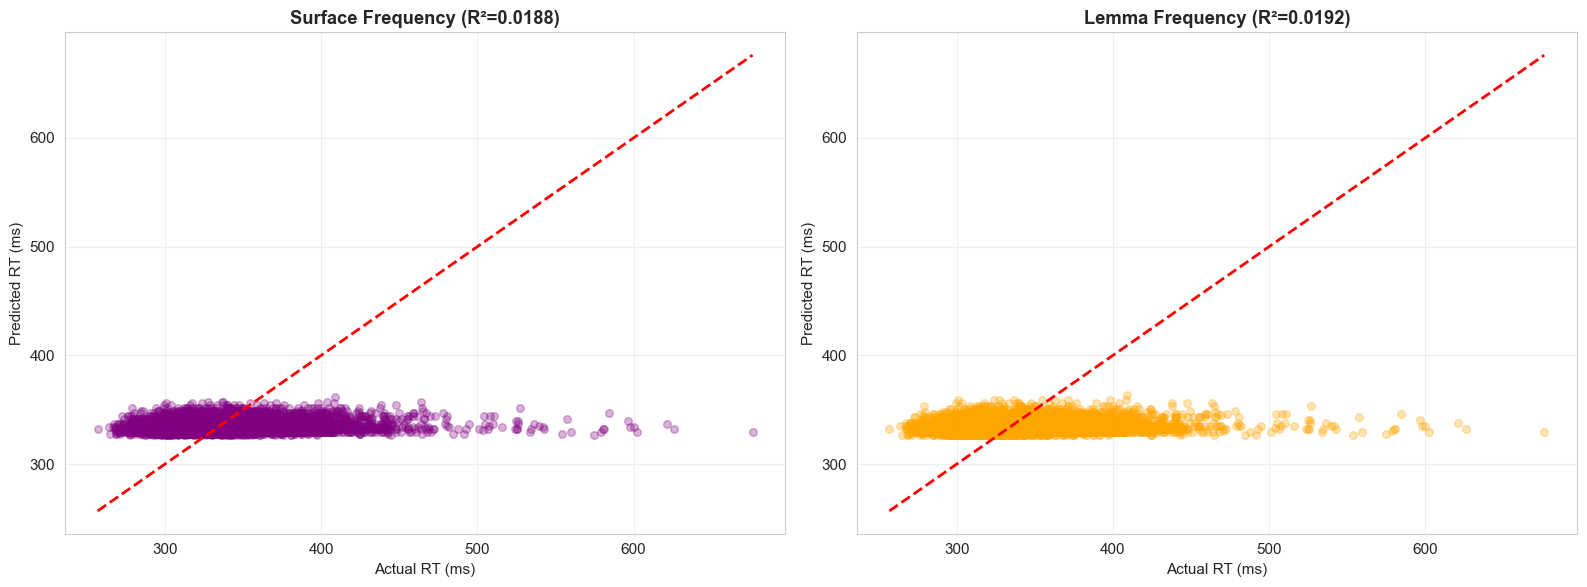

In [25]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

y_pred_p3_1 = model_p3_1.predict(X_p3_1)
y_pred_p3_2 = model_p3_2.predict(X_p3_2)

axes[0].scatter(y_p3, y_pred_p3_1, alpha=0.3, s=30, color='purple')
axes[0].plot([y_p3.min(), y_p3.max()], [y_p3.min(), y_p3.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual RT (ms)')
axes[0].set_ylabel('Predicted RT (ms)')
axes[0].set_title(f'Surface Frequency (R²={r2_p3_1:.4f})', fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].scatter(y_p3, y_pred_p3_2, alpha=0.3, s=30, color='orange')
axes[1].plot([y_p3.min(), y_p3.max()], [y_p3.min(), y_p3.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual RT (ms)')
axes[1].set_ylabel('Predicted RT (ms)')
axes[1].set_title(f'Lemma Frequency (R²={r2_p3_2:.4f})', fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('part3_hypothesis1_surface_vs_lemma.png', dpi=300, bbox_inches='tight')
plt.show()

## Hypothesis 2: Pseudo-Affixes vs Real Affixes

### Manual Selection Approach (Matching 1a.md)

In [23]:
# Find words ending in -er and classify by morphological structure
er_words = data_complete[data_complete['word'].str.lower().str.endswith('er')].copy()

if len(er_words) > 0:
    # Classify: if lemma != word (lowercased), it's derived (real affix)
    er_words['is_derived'] = er_words.apply(
        lambda row: row['lemma'] != row['word'].lower(), axis=1
    )
    
    pseudo_affixed = er_words[~er_words['is_derived']].copy()
    real_affixed = er_words[er_words['is_derived']].copy()
    
    print(f"Words ending in -er: {len(er_words)}")
    print(f"Pseudo-affixed (e.g., finger): {len(pseudo_affixed)}")
    print(f"Real affixed (e.g., driver): {len(real_affixed)}")
    
    if len(pseudo_affixed) > 0 and len(real_affixed) > 0:
        n_compare = min(20, len(pseudo_affixed), len(real_affixed))
        pseudo_sample = pseudo_affixed.sample(min(n_compare, len(pseudo_affixed)), random_state=42)
        real_sample = real_affixed.sample(min(n_compare, len(real_affixed)), random_state=42)
        
        pseudo_mean_rt = pseudo_sample['mean_RT'].mean()
        real_mean_rt = real_sample['mean_RT'].mean()
        
        print(f"\nPseudo-affixed mean RT: {pseudo_mean_rt:.2f} ms")
        print(f"Real affixed mean RT:   {real_mean_rt:.2f} ms")
        print(f"Difference: {pseudo_mean_rt - real_mean_rt:.2f} ms")
        
        t_stat, p_val = ttest_ind(pseudo_sample['mean_RT'], real_sample['mean_RT'])
        print(f"T-test: t={t_stat:.4f}, p={p_val:.4f}")
        print(f"Result: {'Significant' if p_val < 0.05 else 'Not significant'} (α=0.05)")
    else:
        print("\nInsufficient data for comparison (need both types)")
        pseudo_sample = real_sample = None
else:
    print("No -er words found")
    pseudo_sample = real_sample = None

Words ending in -er: 293
Pseudo-affixed (e.g., finger): 185
Real affixed (e.g., driver): 108

Pseudo-affixed mean RT: 332.13 ms
Real affixed mean RT:   335.63 ms
Difference: -3.50 ms
T-test: t=-0.2538, p=0.8010
Result: Not significant (α=0.05)


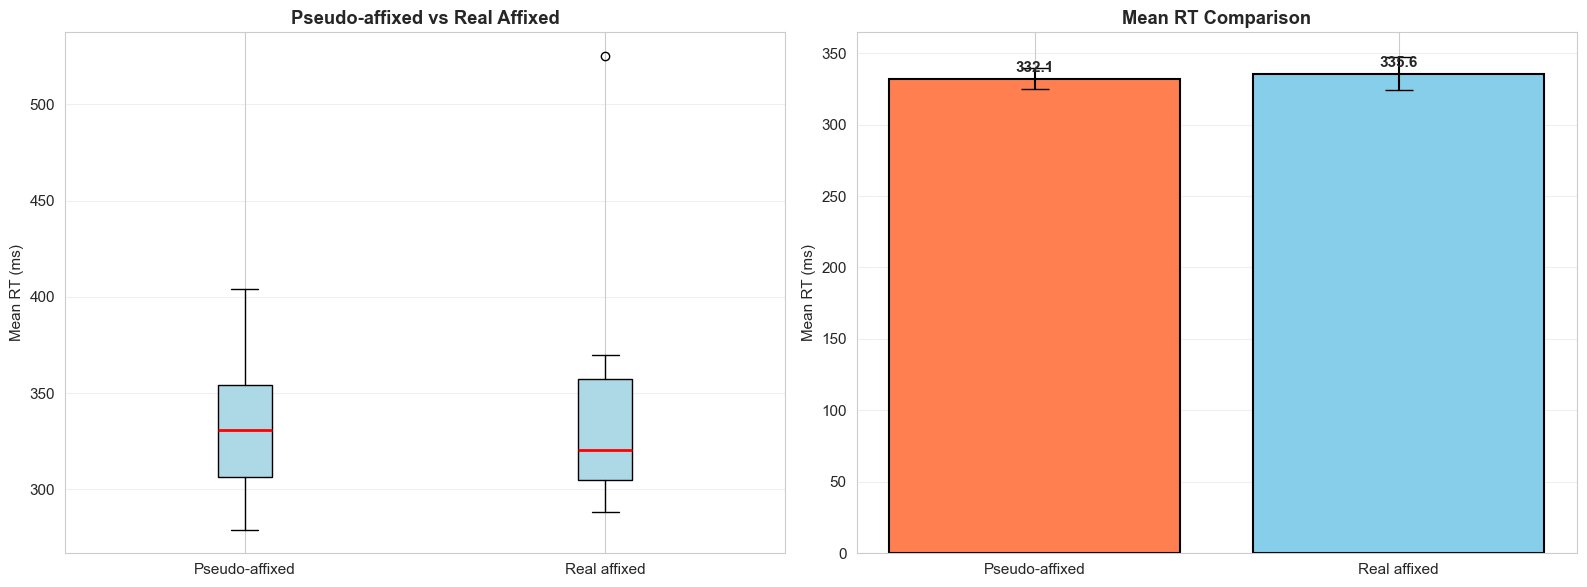

In [24]:
# Visualization
try:
    if 'pseudo_sample' in locals() and 'real_sample' in locals() and \
       pseudo_sample is not None and real_sample is not None and \
       len(pseudo_sample) > 0 and len(real_sample) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Box plot
        axes[0].boxplot([pseudo_sample['mean_RT'], real_sample['mean_RT']],
                        labels=['Pseudo-affixed', 'Real affixed'],
                        patch_artist=True,
                        boxprops=dict(facecolor='lightblue'),
                        medianprops=dict(color='red', linewidth=2))
        axes[0].set_ylabel('Mean RT (ms)')
        axes[0].set_title('Pseudo-affixed vs Real Affixed', fontweight='bold')
        axes[0].grid(alpha=0.3, axis='y')
        
        # Bar plot with error bars
        means = [pseudo_mean_rt, real_mean_rt]
        sems = [pseudo_sample['mean_RT'].sem(), real_sample['mean_RT'].sem()]
        bars = axes[1].bar(['Pseudo-affixed', 'Real affixed'], means, 
                          yerr=sems, capsize=10, color=['coral', 'skyblue'], 
                          edgecolor='black', linewidth=1.5)
        axes[1].set_ylabel('Mean RT (ms)')
        axes[1].set_title('Mean RT Comparison', fontweight='bold')
        axes[1].grid(alpha=0.3, axis='y')
        
        for bar, mean in zip(bars, means):
            axes[1].text(bar.get_x() + bar.get_width()/2, mean + 5,
                        f'{mean:.1f}', ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('part3_hypothesis2_pseudo_vs_real_affixes.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Insufficient data for visualization (need both pseudo-affixed and real affixed words)")
except NameError:
    print("Variables not defined - previous cell may not have found suitable data")

### Manual Word Selection (6-word T-Test as in 1a.md)

In [26]:
# Manual selection of matched words ending in -er
# Frequency range: 500k-10M, Length: 5-7 characters

# Pseudo-affixed words (morphologically simplex)
pseudo_words = ['corner', 'finger', 'never', 'under']
# Real affixed words (derived: base + -er)
real_words = ['teacher', 'maker']

# Get all instances from data
pseudo_instances = data_complete[data_complete['word'].str.lower().isin(pseudo_words)].copy()
real_instances = data_complete[data_complete['word'].str.lower().isin(real_words)].copy()

if len(pseudo_instances) > 0 and len(real_instances) > 0:
    print(f"\n=== Manual Pseudo-Affix Analysis ===")
    print(f"\nPseudo-affixed words: {', '.join(pseudo_words)}")
    print(f"  Instances: {len(pseudo_instances)}, Mean RT: {pseudo_instances['mean_RT'].mean():.2f} ms")
    print(f"  SD: {pseudo_instances['mean_RT'].std():.2f} ms")
    
    print(f"\nReal affixed words: {', '.join(real_words)}")
    print(f"  Instances: {len(real_instances)}, Mean RT: {real_instances['mean_RT'].mean():.2f} ms")
    print(f"  SD: {real_instances['mean_RT'].std():.2f} ms")
    
    # Word-level details
    print(f"\n--- Word Details ---")
    for word in pseudo_words:
        word_data = data_complete[data_complete['word'].str.lower() == word]
        if len(word_data) > 0:
            print(f"  {word}: n={len(word_data)}, freq={word_data['word_freq'].iloc[0]:,.0f}, "
                  f"len={len(word)}, mean_RT={word_data['mean_RT'].mean():.1f} ms")
    
    for word in real_words:
        word_data = data_complete[data_complete['word'].str.lower() == word]
        if len(word_data) > 0:
            print(f"  {word}: n={len(word_data)}, freq={word_data['word_freq'].iloc[0]:,.0f}, "
                  f"len={len(word)}, mean_RT={word_data['mean_RT'].mean():.1f} ms")
    
    # T-test
    t_stat_manual, p_val_manual = ttest_ind(pseudo_instances['mean_RT'], 
                                             real_instances['mean_RT'])
    print(f"\n--- Statistical Test ---")
    print(f"T-test: t = {t_stat_manual:.3f}, p = {p_val_manual:.4f}")
    print(f"Result: {'Significant' if p_val_manual < 0.05 else 'Not significant'} at α=0.05")
else:
    print("Insufficient data for manual comparison")


=== Manual Pseudo-Affix Analysis ===

Pseudo-affixed words: corner, finger, never, under
  Instances: 6, Mean RT: 336.17 ms
  SD: 19.57 ms

Real affixed words: teacher, maker
  Instances: 1, Mean RT: 336.20 ms
  SD: nan ms

--- Word Details ---
  corner: n=1, freq=26,436,546, len=6, mean_RT=316.2 ms
  never: n=3, freq=670,917,654, len=5, mean_RT=341.8 ms
  under: n=2, freq=595,187,154, len=5, mean_RT=337.7 ms
  teacher: n=1, freq=102,444,034, len=7, mean_RT=336.2 ms

--- Statistical Test ---
T-test: t = -0.002, p = 0.9987
Result: Not significant at α=0.05


### Manual Word Selection (6-word comparison as in 1a.md)

In [32]:
# Manual selection of matched words ending in -er
# Frequency range: 500k-10M, Length: 5-7 characters

# Pseudo-affixed words (morphologically simplex)
pseudo_words = ['corner', 'finger', 'never', 'under']
# Real affixed words (derived: base + -er)
real_words = ['teacher', 'maker']

# Get all instances from data
pseudo_instances = data_complete[data_complete['word'].str.lower().isin(pseudo_words)].copy()
real_instances = data_complete[data_complete['word'].str.lower().isin(real_words)].copy()

if len(pseudo_instances) > 0 and len(real_instances) > 0:
    print(f"\n=== Manual Pseudo-Affix Analysis ===")
    print(f"\nPseudo-affixed words: {', '.join(pseudo_words)}")
    print(f"  Instances: {len(pseudo_instances)}, Mean RT: {pseudo_instances['mean_RT'].mean():.2f} ms")
    print(f"  SD: {pseudo_instances['mean_RT'].std():.2f} ms")
    
    print(f"\nReal affixed words: {', '.join(real_words)}")
    print(f"  Instances: {len(real_instances)}, Mean RT: {real_instances['mean_RT'].mean():.2f} ms")
    print(f"  SD: {real_instances['mean_RT'].std():.2f} ms")
    
    # Word-level details
    print(f"\n--- Word Details ---")
    for word in pseudo_words:
        word_data = data_complete[data_complete['word'].str.lower() == word]
        if len(word_data) > 0:
            print(f"  {word}: n={len(word_data)}, freq={word_data['word_freq'].iloc[0]:,.0f}, "
                  f"len={len(word)}, mean_RT={word_data['mean_RT'].mean():.1f} ms")
    
    for word in real_words:
        word_data = data_complete[data_complete['word'].str.lower() == word]
        if len(word_data) > 0:
            print(f"  {word}: n={len(word_data)}, freq={word_data['word_freq'].iloc[0]:,.0f}, "
                  f"len={len(word)}, mean_RT={word_data['mean_RT'].mean():.1f} ms")
    
    # T-test
    t_stat_manual, p_val_manual = ttest_ind(pseudo_instances['mean_RT'], 
                                             real_instances['mean_RT'])
    print(f"\n--- Statistical Test ---")
    print(f"T-test: t = {t_stat_manual:.3f}, p = {p_val_manual:.4f}")
    print(f"Result: {'Significant' if p_val_manual < 0.05 else 'Not significant'} at α=0.05")
    print(f"Interpretation: {'Real affixed words are processed ' + ('faster' if real_instances['mean_RT'].mean() < pseudo_instances['mean_RT'].mean() else 'slower') + ' than pseudo-affixed' if p_val_manual < 0.05 else 'No significant difference in processing times'}")
else:
    print("Insufficient data for manual comparison")


=== Manual Pseudo-Affix Analysis ===

Pseudo-affixed words: corner, finger, never, under
  Instances: 6, Mean RT: 336.17 ms
  SD: 19.57 ms

Real affixed words: teacher, maker
  Instances: 1, Mean RT: 336.20 ms
  SD: nan ms

--- Word Details ---
  corner: n=1, freq=26,436,546, len=6, mean_RT=316.2 ms
  never: n=3, freq=670,917,654, len=5, mean_RT=341.8 ms
  under: n=2, freq=595,187,154, len=5, mean_RT=337.7 ms
  teacher: n=1, freq=102,444,034, len=7, mean_RT=336.2 ms

--- Statistical Test ---
T-test: t = -0.002, p = 0.9987
Result: Not significant at α=0.05
Interpretation: No significant difference in processing times


---
## Export Results

In [29]:
# Save complete dataset
data_complete.to_csv('analysis_results_complete.csv', index=False)

# Save model comparison
model_results = pd.DataFrame({
    'Analysis': ['Part II H1: Freq', 'Part II H1: GPT-3',
                'Part II H2: Content+Freq', 'Part II H2: Content+GPT-3',
                'Part II H2: Function+Freq', 'Part II H2: Function+GPT-3',
                'Part III H1: Surface', 'Part III H1: Lemma'],
    'R²': [r2_1, r2_2, r2_c1, r2_c2, r2_f1, r2_f2, r2_p3_1, r2_p3_2]
})
model_results.to_csv('model_comparison_results.csv', index=False)

print("Results exported successfully!")
print("\nGenerated files:")
print("  - 7 PNG plots (300 DPI)")
print("  - analysis_results_complete.csv")
print("  - model_comparison_results.csv")

Results exported successfully!

Generated files:
  - 7 PNG plots (300 DPI)
  - analysis_results_complete.csv
  - model_comparison_results.csv
